In [1]:
import pandas as pd
import numpy as np
import holidays
import main
import math
import pmdarima as pm
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, Naive #Imports the models you will use
from datetime import date
from dateutil.relativedelta import relativedelta

#INPUT_PATH = "C:/Users/u00378/Desktop/tcc_est_unb"
INPUT_PATH = "C:/Users/Igor/Desktop/TCC"

df = pd.read_pickle(f'{INPUT_PATH}/dados/tcc_data.pkl')

C:\Users\Igor\AppData\Roaming\Python\Python310\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
#########################
### Regiões do brasil ###
#########################
#NORTE ok
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
#NORDESTE ok
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE',\
            'PB', 'SE', 'AL', 'BA']
#CENTRO-OESTE + DF ok
centro_oeste = ['MT', 'MS', 'GO', 'DF']
#SUDESTE ok
sudeste = ['SP', 'RJ', 'ES', 'MG']
#SUL ok
sul = ['PR', 'RS', 'SC']

## Weekday and Holidays

In [3]:
br_holidays = holidays.country_holidays('BR')  # this is a dict
mg_holidays = holidays.country_holidays('BR', subdiv='MG')  # this is a dict

In [4]:
BR_H = list(map(lambda x: br_holidays.get(x), df['data_inversa']))
MG_H = list(map(lambda x: mg_holidays.get(x), df['data_inversa']))

WEEKDAYS = list(map(lambda x: x.weekday(), df['data_inversa']))

#df['event_name'] = map(br_holidays.get(), df['data_inversa'])

In [5]:
BR_H == MG_H

False

In [6]:
df['weekday'] = list(map(lambda x: x.weekday(), df['data_inversa']))
df = pd.get_dummies(df, columns=['weekday'], drop_first=True)

isnt_na = lambda x: False if bool(__import__('pandas').isna(x)) else True
filtro1 = np.array(list(map(isnt_na, df['uf'])))
filtro2 = np.array((list(map(isnt_na, df['br']))))

df_tcc = df[(filtro1) & (filtro2)]

In [18]:
df_tcc

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,longitude,regional,delegacia,uop,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,10.0,2007-06-11,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
1,10.0,2007-06-11,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
2,1032898.0,2007-08-13,Segunda,14:25:00,MG,40,585.5,ITABIRITO,Outras,Saída de Pista,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
3,1051130.0,2007-02-12,Segunda,02:10:00,MA,135,11,SAO LUIS,Animais na Pista,Atropelamento de animal,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
4,1066824.0,2007-11-20,Terça,05:30:00,CE,222,30.8,CAUCAIA,Defeito mecânico em veículo,Capotamento,...,NaN,NaN,NaN,NaN,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002435,524444.0,2023-04-07,sexta-feira,15:15:00,PR,116,126,FAZENDA RIO GRANDE,Condutor deixou de manter distância do veículo...,Colisão traseira,...,"-49,313085",SPRF-PR,DEL01-PR,UOP03-DEL01-PR,0,0,0,1,0,0
2002436,524461.0,2023-04-03,segunda-feira,07:20:00,RS,392,83,PELOTAS,Manobra de mudança de faixa,Colisão frontal,...,"-52,47118546",SPRF-RS,DEL07-RS,UOP01-DEL07-RS,0,0,0,0,0,0
2002437,524498.0,2023-03-13,segunda-feira,16:35:00,SC,470,140,RIO DO SUL,Desrespeitar a preferência no cruzamento,Colisão transversal,...,"-49,662827",SPRF-SC,DEL04-SC,UOP02-DEL04-SC,0,0,0,0,0,0
2002438,524499.0,2023-01-24,terça-feira,17:20:00,PB,230,25,JOAO PESSOA,Reação tardia ou ineficiente do condutor,Colisão lateral mesmo sentido,...,"-34,87847458",SPRF-PB,DEL01-PB,UOP01-DEL01-PB,1,0,0,0,0,0


## Ajuste

### Some tests

In [7]:
train = df_tcc[(df_tcc['uf'] == 'MG') & (df_tcc['data_inversa'] <= '2023-01-31')].groupby('data_inversa')['id'].agg('nunique').resample('D').sum()

test = df_tcc[(df_tcc['uf'] == 'MG') & (df_tcc['data_inversa'] >= '2023-02-01') & (df_tcc['data_inversa'] <= '2023-02-28')]\
    .groupby('data_inversa')['id'].agg('nunique').resample('D').sum()

In [8]:
WEEKDAYS = list(map(lambda x: x.weekday(), train.index))
MG_H = list(map(lambda x: 1 if mg_holidays.get(x) != None else 0, train.index))

exp_var1 = pd.DataFrame({'weekday': WEEKDAYS, 'is_holiday':MG_H})
exp_var1 = pd.get_dummies(exp_var1, columns=['weekday'], drop_first=True)


WEEKDAYS = list(map(lambda x: x.weekday(), test.index))
MG_H = list(map(lambda x: 1 if mg_holidays.get(x) != None else 0, test.index))

exp_var2 = pd.DataFrame({'weekday': WEEKDAYS, 'is_holiday':MG_H})
exp_var2 = pd.get_dummies(exp_var2, columns=['weekday'], drop_first=True)

In [9]:
from statsforecast import StatsForecast
Y_ts = pd.DataFrame({'ds':train.index, 'y':train.values})
Y_ts['unique_id'] = ['MG']*len(Y_ts)

StatsForecast.plot(Y_ts)

In [10]:
Y_train_df = Y_ts[Y_ts.ds <= '2011-01-31']
Y_test_df = Y_ts[(Y_ts.ds <= '2011-02-28') & (Y_ts.ds >= '2011-02-01')]

In [113]:
from statsforecast import StatsForecast #Imports the core StatsForecast class
from statsforecast.models import AutoARIMA, AutoETS, Naive #Imports the models you will use

season_length = 365.25 # Daily data (freq. as week) 
horizon = len(Y_test_df) # Predict the lenght of the test df

In [114]:
# Include the models you imported
models = [
    AutoARIMA(season_length=season_length),
    AutoETS(model = 'ZZZ', season_length=season_length),
    Naive()
]

# Instansiate the StatsForecast class as sf
sf = StatsForecast(
    df=Y_train_df,
    models=models,
    freq='D', 
    n_jobs=-1
)

# Forecast for the defined horizon
Y_hat_df = sf.forecast(horizon)

Y_hat_df.head()

In [14]:
Y_hat_df.reset_index()

,unique_id,ds,AutoARIMA,AutoETS,Naive
0,MG,2011-02-01,80.876740,61.804348,79.0
1,MG,2011-02-02,80.825127,62.691227,79.0
2,MG,2011-02-03,86.073341,66.432922,79.0
3,MG,2011-02-04,86.712433,80.555298,79.0
4,MG,2011-02-05,83.506302,76.046249,79.0
5,MG,2011-02-06,89.643456,79.914719,79.0
6,MG,2011-02-07,84.138199,66.706215,79.0
7,MG,2011-02-08,82.974533,61.804348,79.0
8,MG,2011-02-09,80.926369,62.691227,79.0
9,MG,2011-02-10,84.750175,66.432922,79.0


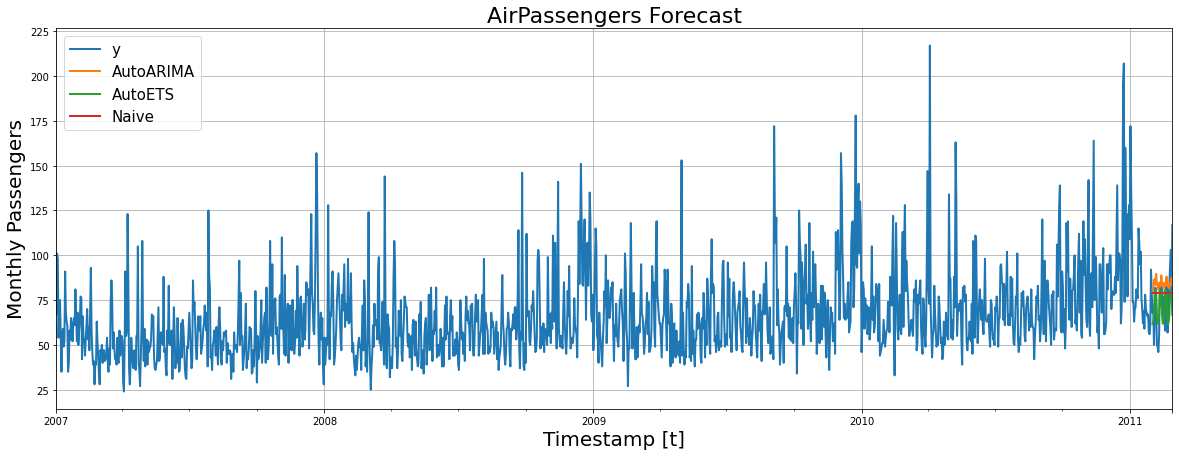

In [15]:
import matplotlib.pyplot as plt

Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA', 'AutoETS', 'Naive']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

plt.show()

In [ ]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
ets_preds = Y_hat_df['ETS'].values
arima_preds = Y_hat_df['AutoARIMA'].values
naive_preds = Y_hat_df['Naive'].values

print('ETS   MAE: %0.3f' % mae(ets_preds, y_true))
print('ARIMA MAE: %0.3f' % mae(arima_preds, y_true))
print('Naive MAE: %0.3f' % mae(naive_preds, y_true))

ETS   MAE: 12.207
ARIMA MAE: 16.574
Naive MAE: 14.321


In [17]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
ets_preds = Y_hat_df['AutoETS'].values
arima_preds = Y_hat_df['AutoARIMA'].values
naive_preds = Y_hat_df['Naive'].values

print('ETS   MAE: %0.3f' % mae(ets_preds, y_true))
print('ARIMA MAE: %0.3f' % mae(arima_preds, y_true))
print('Naive MAE: %0.3f' % mae(naive_preds, y_true))

ETS   MAE: 12.207
ARIMA MAE: 16.574
Naive MAE: 14.321


### Validação cruzada: avaliação por janela deslizante

- Pela função groe() do pacote forecTheta e função tsCV() do pacote forecast:

(a) H = 28; 4 origens; m = 4 anos;

(b) n1 = 2011-01-02; n2 = 2015-01-02; n3 = 2019-01-03; n4 = 2023-01-04.

In [ ]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

for i in np.unique(df_tcc['uf'].dropna()):
    c = 1
    mae_ets= []
    mae_arima= []
    mae_naive= []
    inicial_date = date(2007, 1, 1)
    while c <=4:
        final_date = inicial_date + relativedelta(years=4)
        serie = df_tcc[(df_tcc['uf'] == i) & (df_tcc['data_inversa'] <= '2023-01-31')].groupby('data_inversa')['id'].agg('nunique').resample('D').sum()
        Y_ts = pd.DataFrame({'ds':serie.index, 'y':serie.values})
        Y_ts['unique_id'] = [i]*len(Y_ts)

        Y_train_df = Y_ts[Y_ts.ds <= pd.to_datetime(final_date)]
        Y_test_df = Y_ts[(Y_ts.ds >= pd.to_datetime(final_date+ relativedelta(days=1))) & (Y_ts.ds <=  pd.to_datetime(final_date+ relativedelta(days=28)))]

        season_length = 365.25 # Daily data w/ one seasonal period
        season_lengths = [7, 365.25] # Daily data w/ two  seasonal periods (This should capture the weekly pattern as well as the longer annual pattern)
        horizon = len(Y_test_df) # Predict the lenght of the test df

        # Include the models you imported
        models = [
            AutoARIMA(season_length=season_length),
            AutoETS(model = 'ZZZ', season_length=season_length),
            Naive()
        ]

        # Instansiate the StatsForecast class as sf
        sf = StatsForecast(
            df=Y_train_df,
            models=models,
            freq='D', 
            n_jobs=-1
        )

        # Forecast for the defined horizon
        Y_hat_df = sf.forecast(horizon)
        Y_hat_df.reset_index()

        y_true = Y_test_df['y'].values
        ets_preds = Y_hat_df['ETS'].values
        arima_preds = Y_hat_df['AutoARIMA'].values
        naive_preds = Y_hat_df['Naive'].values
        
        mae_ets = mae_ets.append(mae(ets_preds, y_true))
        mae_arima = mae_arima.append(mae(arima_preds, y_true))
        mae_naive = mae_naive.append(mae(naive_preds, y_true))

        inicial_date = final_date + relativedelta(days=1)
        c +=1

    saida = pd.Data.Frame({'Modelo':['ETS', 'ARIMA', 'Naive'], f'MAE_medio_{i}':\
                           [np.mean(np.array(mae_ets)), np.mean(np.array(mae_arima)), np.mean(np.array(mae_naive))]})\
                            .to_excel(f'{INPUT_PATH}/git_repo/results/cv_{i}.xlsx')
    
    saida = pd.Data.Frame({'Modelo':['ETS', 'ARIMA', 'Naive'], f'MAE_medio_{i}':\
                           [np.mean(np.array(mae_ets)), np.mean(np.array(mae_arima)), np.mean(np.array(mae_naive))]})\
                            .to_excel(f'{INPUT_PATH}/results/cv_{i}.xlsx')

In [111]:

inicial_date = date(2007, 1, 1)
for i in range(1, 5):
    print('i', inicial_date)
    final_date = inicial_date + relativedelta(years=4)
    print('f', final_date)
    inicial_date = final_date + relativedelta(days=1)


i 2007-01-01
f 2011-01-01
i 2011-01-02
f 2015-01-02
i 2015-01-03
f 2019-01-03
i 2019-01-04
f 2023-01-04
